# 3D bounding box model

In this notebook, we design the model that takes training images and 2D bounding box information and outputs 3D bounding boxes.

In [42]:
# Import statements.
from data_processing import parse_annotation, data_gen
from dataset import *
import os
import cv2
import numpy as np
from typing import Dict, Any, List
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.callbacks import History, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, \
    LeakyReLU, Dropout, Reshape, Softmax, Input, Lambda
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

In [30]:
# Global constants.
VGG_INPUT_SHAPE = (224, 224, 3)
DIM_OUT_SHAPE = 3
ORIENT_OUT_SHAPE = (2, 2)
CONF_OUT_SHAPE = 2
DEFAULT_MODEL_ARGS = {'input_shape': (224, 224, 3)}
DEFAULT_TRAIN_ARGS = {'epochs': 5,
                      'batch_size': 32,
                      'use_tensorboard': False,
                      'model_checkpoint_filename': None}
DIMS_AVG = {'Cyclist': np.array([1.73532436, 0.58028152, 1.77413709]),
            'Van': np.array([2.18928571, 1.90979592, 5.07087755]),
            'Tram': np.array([3.56092896, 2.39601093, 18.34125683]),
            'Car': np.array([1.52159147, 1.64443089, 3.85813679]),
            'Pedestrian': np.array([1.75554637, 0.66860882, 0.87623049]),
            'Truck': np.array([3.07392252, 2.63079903, 11.2190799])}
VEHICLES = ['Car', 'Truck', 'Van', 'Tram', 'Pedestrian', 'Cyclist']

In [19]:
def orientation_loss(y_true: np.ndarray, y_pred: np.ndarray) -> tf.Tensor:
    """Returns the orientation loss from the predictions.
    :param y_true: The true orientation, a tensor of shape (None, 2, 2).
    :param y_pred: The predicted orientation of the same shape.
    :return: The orientation loss as a tensor.
    """
    anchors = tf.reduce_sum(tf.square(y_true), axis=2)
    anchors = tf.greater(anchors, tf.constant(0.5))
    anchors = tf.reduce_sum(tf.cast(anchors, tf.float32), 1)
    loss = (y_true[:, :, 0] * y_pred[:, :, 0] + y_true[:, :, 1] * \
            y_pred[:, :, 1])
    loss = tf.reduce_sum((2 - 2 * tf.reduce_mean(loss, axis=0))) / anchors
    return tf.reduce_mean(loss)

In [20]:
def get_model_3d_deepbox() -> Model:
    """Returns the model used in the 3D-deepbox paper. Uses a VGG16 base. The
    model takes as input images of shape VGG_INPUT_SHAPE and outputs 3 tensors:
    dimensions (None, 3), orientation (None, 2, 2), confidence (None, 2).
    :return: The model.
    """
    vgg = VGG16(weights='imagenet', include_top=False,
                input_shape=VGG_INPUT_SHAPE)
    conv5 = Flatten()(vgg.output)
    dim_out = Dense(512, activation=None)(conv5)
    dim_out = LeakyReLU(alpha=0.1)(dim_out)
    dim_out = Dropout(rate=0.5)(dim_out)
    dim_out = Dense(DIM_OUT_SHAPE, activation=None)(dim_out)
    orient_out = Dense(256, activation=None)(conv5)
    orient_out = LeakyReLU(alpha=0.1)(orient_out)
    orient_out = Dropout(rate=0.5)(orient_out)
    orient_out = Dense(ORIENT_OUT_SHAPE[0] * ORIENT_OUT_SHAPE[1],
                       activation=None)(orient_out)
    orient_out = Reshape((ORIENT_OUT_SHAPE[0], ORIENT_OUT_SHAPE[1]))(orient_out)
    orient_out = Lambda(lambda x: K.l2_normalize(x, axis=2))(orient_out)
    conf_out = Dense(256, activation=None)(conv5)
    conf_out = LeakyReLU(alpha=0.1)(conf_out)
    conf_out = Dropout(rate=0.5)(conf_out)
    conf_out = Dense(CONF_OUT_SHAPE, activation=None)(conf_out)
    conf_out = Softmax()(conf_out)
    model = Model(inputs=vgg.input, outputs=[dim_out, orient_out, conf_out])
    model.compile(loss=[tf.keras.losses.mean_squared_error,
                        orientation_loss,
                        tf.keras.losses.categorical_crossentropy],
                  loss_weights=[4, 8, 1],
                  optimizer='adam')
    return model

In [21]:
def train(model: Model,
          partition: Dict[str, List[str]],
          image_dir: str,
          label_dir: str,
          train_args: Dict[str, Any] = DEFAULT_TRAIN_ARGS) -> History:
    """Trains the model and returns the history.
    :param model: The model.
    :param partition: The partition.
    :param image_dir: The directory in which the training images are stored.
    :param label_dir: The directory in which the labels are stored.
    :param train_args: A dictionary specifying the training hyperparameters.
    :return: The training history object.    
    """
    train_objs = parse_annotation(partition[TRAIN_KEY], label_dir)
    val_objs = parse_annotation(partition[VAL_KEY], label_dir)
    np.random.shuffle(train_objs)
    np.random.shuffle(val_objs)
    train_gen = data_gen(image_dir, train_objs, train_args['batch_size'])
    val_gen = data_gen(image_dir, val_objs, train_args['batch_size'])
    train_steps = int(np.ceil(len(train_objs) / train_args['batch_size']))
    val_steps = int(np.ceil(len(val_objs) / train_args['batch_size']))
    callbacks = []
    if train_args['use_tensorboard']:
        log_dir = 'logs_{0}'.format(datetime.now())
        tensorboard_callback = TensorBoard(log_dir=log_dir)
        callbacks.append(tensorboard_callback)
    if train_args['model_checkpoint_filename']:
        checkpoint_callback = ModelCheckpoint(
            train_args['model_checkpoint_filename'],
            save_best_only=True)
        callbacks.append(checkpoint_callback) 
    return model.fit(
        x=train_gen,
        epochs=train_args['epochs'],
        callbacks=callbacks,
        validation_data=val_gen,
        steps_per_epoch=train_steps,
        validation_steps=val_steps)

In [22]:
def evaluate(model, partition, labels, image_dir) -> Dict[str, Any]:
    # TODO
    return None

In [39]:
def predict_on_dir(model: Model, image_filenames: List[str], image_dir: str,
                   box2d_dir: str, result_dir: str) -> None:
    """Runs the model prediction on all the images in image_filenames and writes
    the results in label file format to result_dir.
    :param model: The (trained) model.
    :param image_filenames: The images in image_dir on which to predict.
    :param image_dir: The directory containing the images.
    :param box2d_dir: The directory containing the 2D bounding box labels
    (either predicted or ground truth).
    :param result_dir: The directory to which the resulting label files should
    be saved.
    """
    for image_filename in tqdm(image_filenames):
        image_file = os.path.join(image_dir, image_filename)
        box2d_file = os.path.join(box2d_dir,
                                  image_filename.replace('.png', '.txt'))
        if not os.path.exists(box2d_file):
            continue
        box3d_file = os.path.join(result_dir,
                                  image_filename.replace('.png', '.txt'))
        with open(box3d_file, 'w') as box3d:
            img = cv2.imread(image_file)
            img = img.astype(np.float32, copy=False)
            with open(box2d_file, 'r') as box2d:
                for line in box2d:
                    obj = get_label_obj(line)
                    patch = img[int(obj['y1']):int(obj['y2']),
                                int(obj['x1']):int(obj['x2'])]
                    patch = cv2.resize(patch, model.input_shape[1:3])
                    patch /= 255.
                    patch = np.expand_dims(patch, 0)
                    prediction = model.predict(patch)
                    # Transform regressed angle.
                    max_anc = np.argmax(prediction[2][0])
                    anchors = prediction[1][0][max_anc]
                    if anchors[1] > 0:
                        angle_offset = np.arccos(anchors[0])
                    else:
                        angle_offset = -np.arccos(anchors[0])
                    wedge = np.pi
                    angle_offset = angle_offset + max_anc * wedge
                    angle_offset = angle_offset % (2. * np.pi)
                    angle_offset = angle_offset - np.pi / 2
                    if angle_offset > np.pi:
                        angle_offset = angle_offset - (2. * np.pi)
                    line = line.strip().split(' ')
                    line[3] = str(angle_offset)
                    line[14] = angle_offset + np.arctan(
                        float(line[11]) / float(line[13]))
                    # Transform regressed dimension.
                    if line[0] in VEHICLES:
                        dims = DIMS_AVG[line[0]] + prediction[0][0]
                    else:
                        dims = DIMS_AVG['Car'] + prediction[0][0]
                    line = line[:8] + list(dims) + line[11:]
                    # Write regressed 3D dim and orient to file.
                    line = ' '.join([str(item) for item in line]) + ' ' + str(
                        np.max(prediction[2][0])) + '\n'
                    box3d.write(line)

In [ ]:
def smooth_curve(points: List[float], factor: float = 0.6) -> List[float]:
    """Returns points smoothed over an exponential.
    :param points: The points of the curve to smooth.
    :param factor: The smoothing factor.
    :return: The smoothed points.
    """
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [ ]:
def plot_history(history: History, smooth_fac: float = 0.6) -> None:
    """Plots the training history. You can also visualize the training process
    in Tensorboard or wandb.
    :param history: The training history.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, smooth_curve(acc, factor=smooth_fac), 'bo',
             label='Smoothed training acc')
    plt.plot(epochs, smooth_curve(val_acc, factor=smooth_fac), 'b',
             label='Smoothed validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
    plt.plot(epochs, smooth_curve(val_loss), 'b',
             label='Smoothed validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [24]:
partition = get_train_only_kitti_partition(TRAIN_IMAGE_DIR)

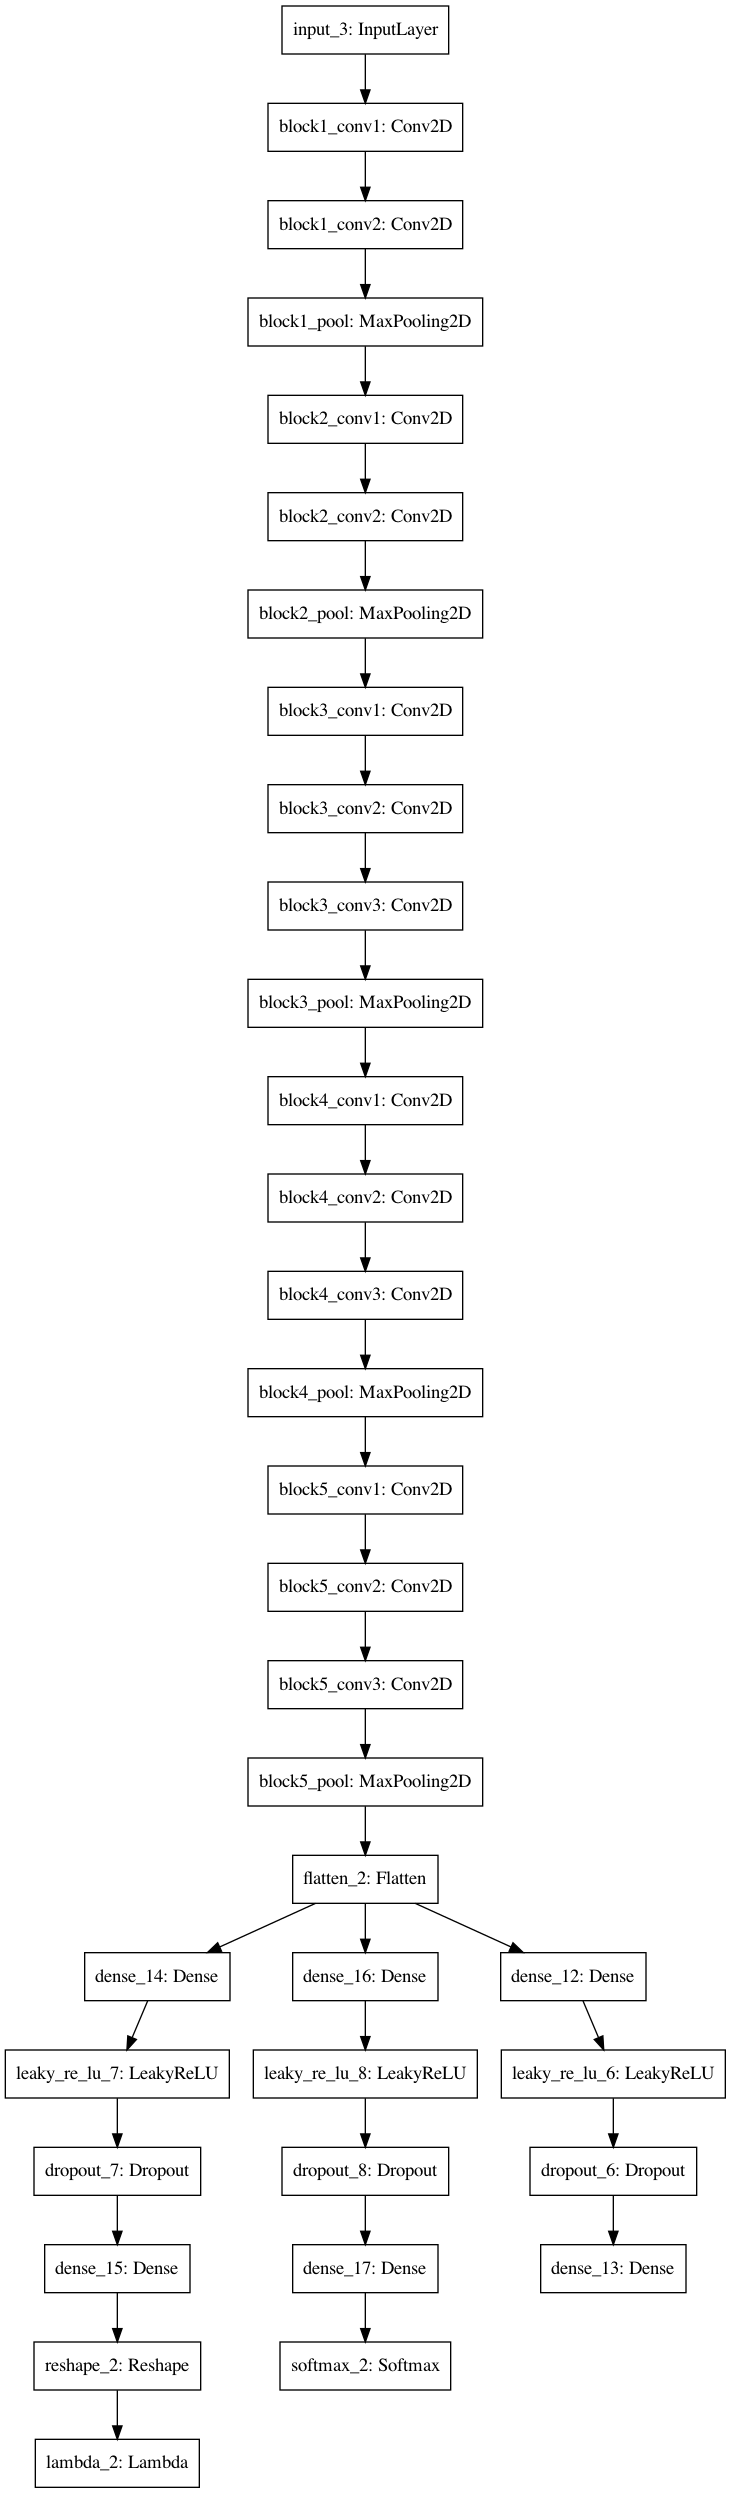

In [25]:
model = get_model_3d_deepbox()
plot_model(model)

In [28]:
train_args = DEFAULT_TRAIN_ARGS
train_args['model_checkpoint_filename'] = os.path.join('..', 'model',
                                                       'model_3d_deepbox.h5')
history = train(model, partition, TRAIN_IMAGE_DIR, LABEL_DIR)

Epoch 1/5
346/346 [==============================] - 3769s 11s/step - loss: 24724.5246 - dense_13_loss: 6174.7877 - lambda_2_loss: 2.2792 - softmax_2_loss: 7.1423 - val_loss: 19.4903 - val_dense_13_loss: 0.3339 - val_lambda_2_loss: 2.1814 - val_softmax_2_loss: 0.7035
Epoch 2/5
 16/346 [>.............................] - ETA: 54:33 - loss: 18.8797 - dense_13_loss: 0.1489 - lambda_2_loss: 2.1994 - softmax_2_loss: 0.6888

KeyboardInterrupt: 

In [ ]:
plot_history(history)

In [40]:
predict_on_dir(model, partition[TRAIN_KEY], TRAIN_IMAGE_DIR, LABEL_DIR,
               PREDICTION_3D_BOX_DIR_TRAIN)

  3%|▎         | 163/5237 [02:39<1:22:31,  1.02it/s]


KeyboardInterrupt: 

In [41]:
predict_on_dir(model, partition[VAL_KEY], TRAIN_IMAGE_DIR, LABEL_DIR,
               PREDICTION_3D_BOX_DIR_VAL)

  2%|▏         | 37/1496 [00:28<18:49,  1.29it/s]


KeyboardInterrupt: 

In [ ]:
predict_on_dir(model, partition[TEST_KEY], TRAIN_IMAGE_DIR, LABEL_DIR,
               PREDICTION_3D_BOX_DIR_TEST)